# Week 4 - Function 2 ((13DP, 2D))

# Setup
Let's load all the imports in the top to avoid repeating and simplify the readability of each solution.

In [1]:
import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from utils.plotting_utils import plot_2D_mean_uncertainty, plot_bar

# Plan
We now have ((13, 2)) - 13DP & 2D that can be found `./data/week_4/function_2/`.

1. Load data
2. Build probabilistic Model
3. Acquisition Function

# 1. Load data

Shape: X=(13, 2), y=(13,)
X range: [0.0287, 0.9266]
y range: [-0.0656, 0.6112]


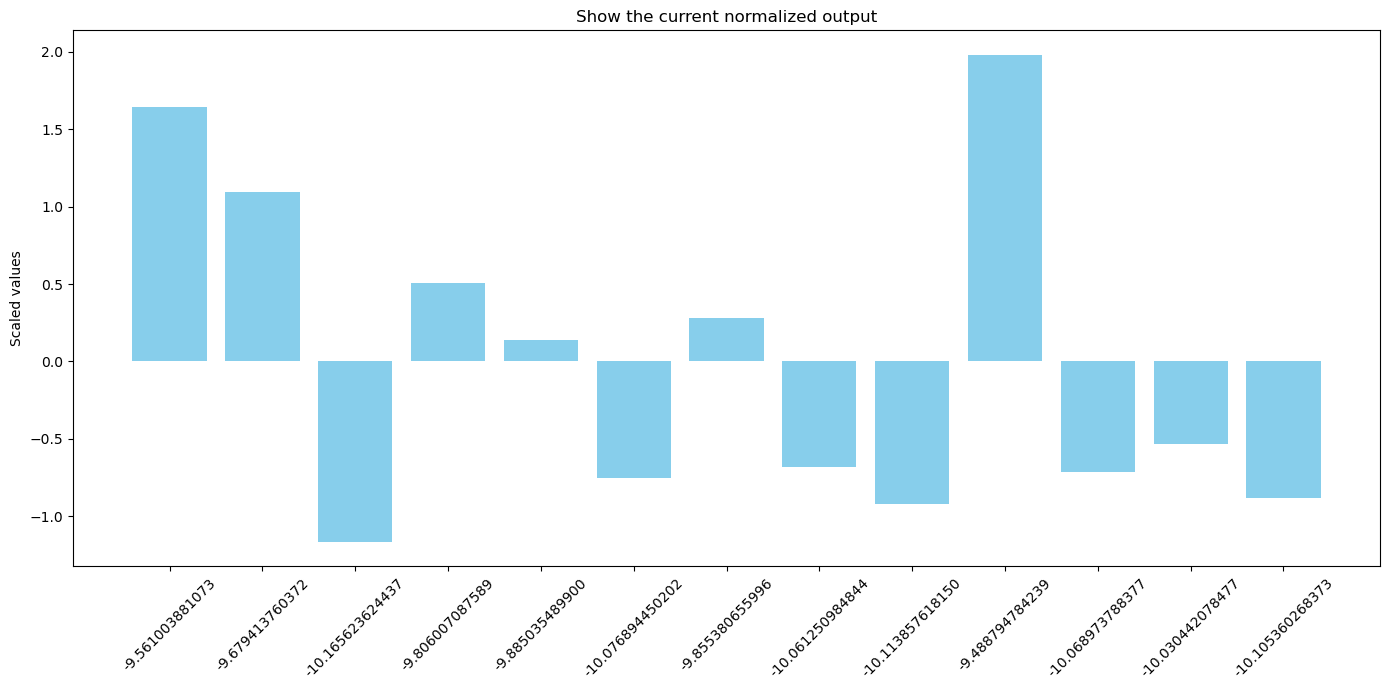

In [2]:
X_train_raw = np.load(r"./data/week_4/function_2/inputs.npy")
y_train_raw = np.load(r"./data/week_4/function_2/outputs.npy")

print(f"Shape: X={X_train_raw.shape}, y={y_train_raw.shape}")
print(f"X range: [{X_train_raw.min():.4f}, {X_train_raw.max():.4f}]")
print(f"y range: [{y_train_raw.min():.4f}, {y_train_raw.max():.4f}]")

scaler_X = MinMaxScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train_raw)
y_train = scaler_y.fit_transform(y_train_raw.reshape(-1, 1)).ravel()

plot_bar(y_train_raw, y_train, 'Scaled values', 'Show the current normalized output')

# 2. Build probabilistic Model

From early exploration we know that:
- No outliers in the initial data
- Data contains variation in outputs


## Kernel choice
I don't see anything concerning with the different outputs so in this case I will use a Matérn kernel.

Optimized Kernel: 2.89**2 * Matern(length_scale=0.4, nu=1.5)


/opt/anaconda3/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.4. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


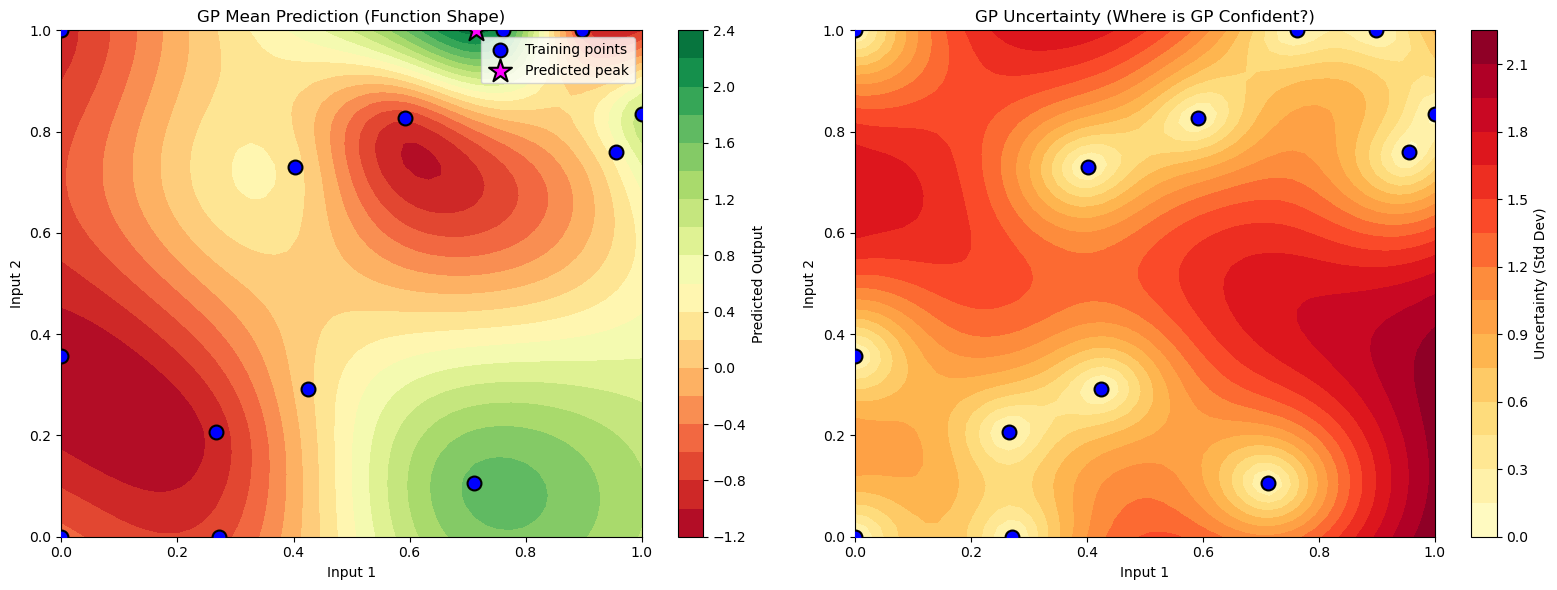

In [3]:
model = GaussianProcessRegressor(
    kernel=ConstantKernel(0.25, (1e-3, 10)) * Matern(
        length_scale=.5,
        length_scale_bounds=(.4, 5.0)
    ),
    alpha=1e-6,
    normalize_y=True,
    n_restarts_optimizer=10
)

model.fit(X_train, y_train)
print(f"Optimized Kernel: {model.kernel_}")

# Create prediction grid
n_grid = 50
x1_range = np.linspace(0, 1, n_grid)
x2_range = np.linspace(0, 1, n_grid)

X1_test, X2_test = np.meshgrid(x1_range, x2_range)
X_grid = np.c_[X1_test.ravel(), X2_test.ravel()]

# Make predictions
mu, sigma = model.predict(X_grid, return_std=True)

plot_2D_mean_uncertainty(
   X_train,
   X1_test,
   X2_test,
   mu,
   sigma,
)

# 3. Acquisition function

From early exploration we know that:
- No outliers in the initial data
- Data contains variation in outputs
- Low dimension

The data is well-behaved (smooth range, no extreme outliers) so StandardScaler preserves the structure well. Using UCB with the standard kappa=2.0 gives a balanced exploration-exploitation trade-off — unlike function_1 where extreme data required high kappa for exploration, here the GP mean is informative and should be weighted equally.

In [4]:
def upper_confidence_bound(mu, sigma, kappa=2.0):
    """
    Upper Confidence Bound (UCB) acquisition function.
    
    UCB = mean + kappa * std
    
    Parameters:
    -----------
    mu : predicted mean
    sigma : predicted standard deviation
    kappa : exploration parameter (higher = more exploration)
    """
    return mu + kappa * sigma


ucb_values = upper_confidence_bound(mu, sigma, kappa=2.0)

print(f"\nUpper Confidence Bound (UCB):")
print(f"  Min: {ucb_values.min():.8f}")
print(f"  Max: {ucb_values.max():.8f}")
print(f"  Mean: {ucb_values.mean():.8f}")

print("\nFinding best next point to evaluate...")

best_idx = np.argmax(ucb_values)
x_next_norm = X_grid[best_idx]
ucb_best = ucb_values[best_idx]

# Convert to original space
x_next_orig = scaler_X.inverse_transform([x_next_norm])[0]

print(f"\n{'='*80}")
print(f"RECOMMENDED NEXT POINT")
print(f"{'='*80}")
print(f"  Input: [{x_next_orig[0]:.6f}, {x_next_orig[1]:.6f}]")

# Get prediction at this point
y_pred_next, y_std_next = model.predict([x_next_norm], return_std=True)
y_pred_next_orig = scaler_y.inverse_transform([[y_pred_next[0]]])[0, 0]

print(f"\nPredicted output at this point:")
print(f"  {y_pred_next_orig:.6f}")
print(f"  95% CI: [{y_pred_next_orig - 1.96*y_std_next[0]:.6f}, {y_pred_next_orig + 1.96*y_std_next[0]:.6f}]")

print(f"\nUCB at this point: {ucb_best:.6f}")
print(f"UCB Range: {ucb_values.min():.4f} to {ucb_values.max():.4f}")

print(f"\nCurrent best: X=[{X_train_raw[np.argmax(y_train_raw)][0]:.4f}, {X_train_raw[np.argmax(y_train_raw)][1]:.4f}], y={y_train_raw.max():.6f}")


Upper Confidence Bound (UCB):
  Min: -0.95884201
  Max: 5.63722552
  Mean: 2.30830386

Finding best next point to evaluate...

RECOMMENDED NEXT POINT
  Input: [0.877791, 0.028698]

Predicted output at this point:
  0.439479
  95% CI: [-3.925046, 4.804004]

UCB at this point: 5.637226
UCB Range: -0.9588 to 5.6372

Current best: X=[0.7026, 0.9266], y=0.611205
